# Digital Musicology (DH-401)
## Assignment 3: Similarity
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

In [1]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy import signal, interpolate
from itertools import combinations
pd.set_option('display.max_rows', 500)

## 0. Dataset preparation

In [2]:
%%time

# Suppress SettingWithCopy warnings
pd.options.mode.chained_assignment = None

# Import CSV
chorales_dataset = pd.read_csv('DM 2022 - Assignment 3 [Dataset].csv', converters = {'mn_onset': fractions.Fraction, 'act_dur': fractions.Fraction, 'duration': fractions.Fraction, 'nominal_duration': fractions.Fraction, 'scalar': fractions.Fraction}, index_col = 0, low_memory = False)

## Add global onset column for easy time series manipulations (in units of whole notes)
# Sort accordingly
chorales_dataset = chorales_dataset.sort_values(by=['piece', 'staff', 'mn', 'mn_onset'])
# Shift duration column by 1
chorales_dataset['_shift_dur'] = np.roll(chorales_dataset['duration'], 1)
# Get invalid first shifts that will be removed
chorales_dataset['_first_shift'] = chorales_dataset.groupby(['piece','staff'])['_shift_dur'].transform('first')
# Cumulate shifted durations
chorales_dataset['_cum_dur_uncleaned'] = chorales_dataset.groupby(['piece','staff'])['_shift_dur'].transform(pd.Series.cumsum)
# Subtract invalid first shifts
chorales_dataset['global_onset'] = (chorales_dataset['_cum_dur_uncleaned'] - chorales_dataset['_first_shift'])
# Remove temp coliumns
chorales_dataset = chorales_dataset.drop(columns = ['_shift_dur','_first_shift','_cum_dur_uncleaned'])

# Ignore gracenotes (there is only one)
chorales_dataset = chorales_dataset[chorales_dataset['gracenote'].isna()].drop(columns = ['gracenote'])

# Remove Chorale043 because it is corrupted (it does not open in MuseScore, it does not include a closing fermata, and it has only 1 staff)
chorales_dataset = chorales_dataset[chorales_dataset['piece'] != 'BachChorales/Chorale043']

# Get unique piece/staff pairs
piece_staffs = chorales_dataset.groupby('piece')['staff'].unique().to_dict()

# Consider only until the fermata in or after the 4th bar
fermata_data = []
for piece in piece_staffs.keys():
    for staff in piece_staffs[piece]:
        for idx, row in chorales_dataset[(chorales_dataset['piece'] == piece) & (chorales_dataset['staff'] == staff)].iterrows():
            fermata_data.append(row)
            if row['fermata'] and row['mn'] >= 4:
                break
fermata_df = pd.DataFrame(fermata_data)

# Sort by onset and staff for consistent alignment
fermata_df = fermata_df.sort_values(by=['piece', 'mn', 'mn_onset', 'staff']).reset_index(drop=True)

# Create dictionaries of last onsets, total piece durations, and smallest notes in each piece for future use
last_piece_onsets = fermata_df.groupby('piece')['global_onset'].max().apply(float).to_dict()
total_piece_durations = fermata_df.groupby(['piece','staff'])['duration'].sum().groupby('piece').max().apply(float).to_dict()
minimum_note_durations = fermata_df.groupby('piece')['duration'].min().apply(float).to_dict()

CPU times: user 15.4 s, sys: 295 ms, total: 15.7 s
Wall time: 16.2 s


In [3]:
# Display dataframe for random piece up to desired fermata
random_piece = fermata_df['piece'].sample(n=1).item()
random_piece_df = fermata_df[(fermata_df['piece'] == random_piece)]
random_piece_df

,piece,mn,mn_onset,timesig,act_dur,staff,voice,duration,nominal_duration,scalar,tied,tpc,midi,fermata,global_onset
3270,BachChorales/Chorale046,0,3/4,4/4,1/4,1,1,1/4,1/4,1,NaN,2,74,False,0
3271,BachChorales/Chorale046,0,3/4,4/4,1/4,2,1,1/4,1/4,1,NaN,3,69,False,0
3272,BachChorales/Chorale046,0,3/4,4/4,1/4,3,1,1/4,1/4,1,NaN,6,66,False,0
3273,BachChorales/Chorale046,0,3/4,4/4,1/4,4,1,1/4,1/4,1,NaN,2,50,False,0
3274,BachChorales/Chorale046,1,0,4/4,1,1,1,1/4,1/4,1,NaN,7,73,False,1/4
3275,BachChorales/Chorale046,1,0,4/4,1,2,1,1/8,1/8,1,NaN,3,69,False,1/4
3276,BachChorales/Chorale046,1,0,4/4,1,3,1,1/4,1/4,1,NaN,4,64,False,1/4
3277,BachChorales/Chorale046,1,0,4/4,1,4,1,1/4,1/4,1,1.0,3,57,False,1/4
3278,BachChorales/Chorale046,1,1/8,4/4,1,2,1,1/8,1/8,1,NaN,8,68,False,3/8
3279,BachChorales/Chorale046,1,1/4,4/4,1,1,1,1/4,1/4,1,NaN,5,71,False,1/2


## I. Similarity parameters
### a. Rhythm

In [4]:
%%time

# Sum durations of notes in each sampling bin
summed_durations_dict = {}
# Loop
for piece in piece_staffs.keys():
    piece_df = fermata_df[fermata_df['piece'] == piece]

    last_onset = last_piece_onsets[piece]
    sampling_period = minimum_note_durations[piece]

    bins = np.arange(0, (last_onset+sampling_period+1e-10), sampling_period)
    binned_onsets = pd.cut(piece_df['global_onset'], bins, right = True)
    summed_durations_dict[piece] = piece_df.groupby(binned_onsets)['duration'].sum().apply(float)

CPU times: user 4.77 s, sys: 76.5 ms, total: 4.85 s
Wall time: 5.46 s


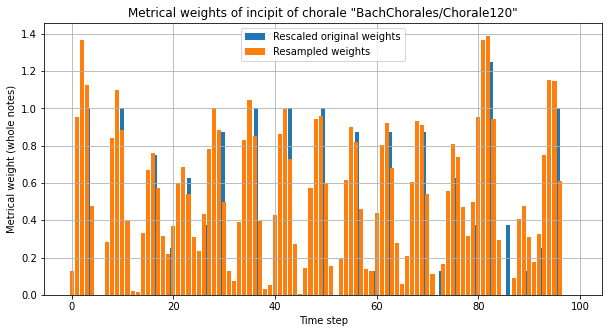

In [24]:
random_piece = fermata_df['piece'].sample(n=1).item()

last_onset = last_piece_onsets[random_piece]
sampling_period = minimum_note_durations[random_piece]
time_steps = np.arange(0, last_onset+1e-10, sampling_period)
summed_durations = summed_durations_dict[random_piece].values

# Sample 100 equally spaced weights
N = 100
time_steps_resampled = np.arange(0, N, 1)
summed_durations_resampled = [max(res, 0) for res in signal.resample(summed_durations, num=N)]

plt.figure(figsize=(10, 5))
plt.bar(time_steps*(N-1)/last_piece_onsets[random_piece], summed_durations)
plt.bar(time_steps_resampled, summed_durations_resampled)
plt.xlabel('Time step')
plt.ylabel('Metrical weight (whole notes)')
plt.title(f'Metrical weights of incipit of chorale "{random_piece}"')
plt.legend(['Rescaled original weights', 'Resampled weights'])
plt.grid()
plt.show()

In [6]:
# compute Euclidean distance between two random pieces for similarity
def eucli_similarity(a,b):
    sum_similarity=0
    for i in range(min(len(a),len(b))):
        ab_dist=np.sqrt(np.sum(np.square(a[i]-b[i]))) # Euclidean distance between two points
        ab_similarity=1/(1+ab_dist)
        sum_similarity=sum_similarity+ab_similarity
    avg_similarity=sum_similarity/min(len(a),len(b)) # average similarity
    return avg_similarity

In [7]:
random_piece = fermata_df['piece'].sample(n=1).item()
summed_durations_1 = summed_durations_dict[random_piece].values
print(random_piece)

BachChorales/Chorale285


In [8]:
random_piece = fermata_df['piece'].sample(n=1).item()
summed_durations_2 = summed_durations_dict[random_piece].values
print(random_piece)

BachChorales/Chorale080


In [9]:
print('The rhythm similarity between two pieces is', eucli_similarity(summed_durations_1,summed_durations_2))

The rhythm similarity between two pieces is 0.8856715301159747


### b. Melodic contour

In [10]:
%%time

# Create dictionary of frontfilled pitches for each piece and staff in each sampling bin
piece_staff_pitches_dict = {}
# Loop
for piece in piece_staffs.keys():
    for staff in piece_staffs[piece]:
        piece_staff_df = fermata_df[(fermata_df['piece'] == piece) & (fermata_df['staff'] == staff)]

        total_duration = total_piece_durations[piece]
        sampling_period = minimum_note_durations[piece]
        
        # Create equally spaced and normalized bins sampled by minimum note resolution
        bins = np.arange(0, 1+1e-10, sampling_period/total_duration)
        binned_onsets = pd.cut(piece_staff_df['global_onset'], bins, right = False)
        # Front fill midi values as long as the onset lasts  
        piece_staff_pitches_dict[(piece,staff)] = piece_staff_df.groupby(binned_onsets)['midi'].first().ffill()

# Get mean pitches for each piece
# This is done by calculating the sum of pitches across staves and dividing by the number of staves
mean_pitches_dict = {}
for piece in piece_staffs.keys():
    cumsum = 0
    for staff in piece_staffs[piece]:
        cumsum += piece_staff_pitches_dict[(piece,staff)]
    mean_pitches_dict[piece] = cumsum / staff

# Manipulate data to get time series vs. pitches for each piece
melodic_contours = {}
for piece in piece_staffs.keys():
    time_steps = np.arange(0, 1+1e-10, minimum_note_durations[piece]/total_piece_durations[piece])
    pitches = mean_pitches_dict[piece].values
    # Front fill up to final normalized duration
    pitches = np.append(pitches, pitches[-1])
    melodic_contours[piece] = (time_steps,pitches)

CPU times: user 14.2 s, sys: 156 ms, total: 14.3 s
Wall time: 14.9 s


In [11]:
# f = interpolate.interp1d(time_steps, pitches, kind='zero')
# xnew = np.arange(0, max(time_steps), max(time_steps)/100)
# ynew = f(xnew)
# plt.figure(figsize=(10, 5))
# plt.step(time_steps/max(time_steps)*99, pitches, '--', xnew/max(time_steps)*99, ynew, '-', time_steps_r,res, '-', )
# plt.show()

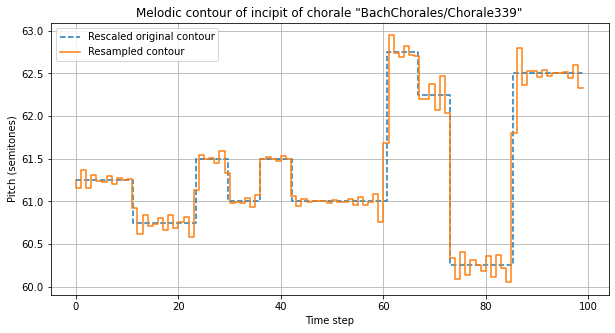

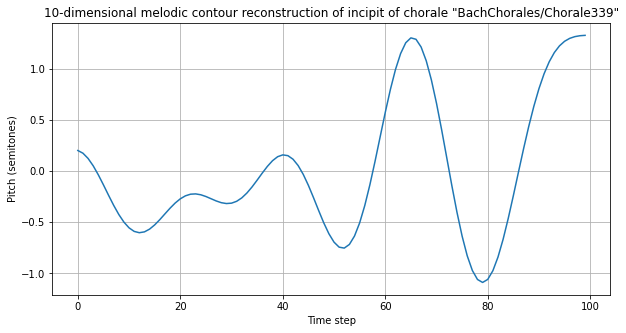

In [17]:
# Plot melodic contour of a random phrase
random_piece = fermata_df['piece'].sample(n=1).item()

time_steps = melodic_contours[random_piece][0]
pitches = melodic_contours[random_piece][1]

# Sample 100 equally spaced pitches
N = 100
time_steps_resampled = np.arange(0, N, 1)
pitches_resampled = signal.resample(pitches, num=N)

plt.figure(figsize=(10, 5))
plt.step(time_steps*(N-1), pitches, '--', time_steps_resampled, pitches_resampled, '-')
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.title(f'Melodic contour of incipit of chorale "{random_piece}"')
plt.legend(['Rescaled original contour', 'Resampled contour'])
plt.grid()
plt.show()

# Compute Discrete Cosine transform of signal
phrase_dct = dct(pitches_resampled, norm='ortho', n=N)

# Discard first coefficient c0 to make contour transposition invariant
phrase_dct[0] = 0

# Reconstruct the phrase using only D dimensions
D = 10
reconstructed_phrase = idct(phrase_dct[0:D], norm='ortho', n=N)
plt.figure(figsize=(10, 5))
plt.title(f'{D}-dimensional melodic contour reconstruction of incipit of chorale "{random_piece}"')
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
plt.plot(reconstructed_phrase)
plt.show()

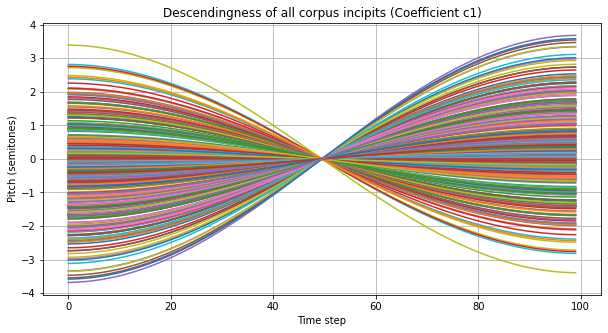

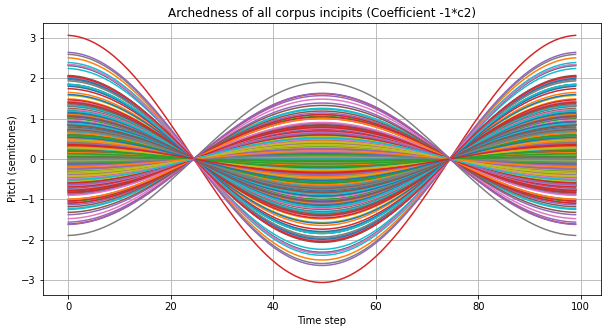

In [13]:
plt.figure(figsize=(10, 5))
plt.title("Descendingness of all corpus incipits (Coefficient c1)")
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
for piece in piece_staffs.keys():
    time_steps = melodic_contours[piece][0]
    pitches = melodic_contours[piece][1]
    
    # Sample 100 equally spaced pitches
    N = 100
    time_steps_resampled = np.arange(0, N, 1)
    pitches_resampled = signal.resample(pitches, num=N)

    # Compute Discrete Cosine transform of signal
    desc_dct = dct(pitches_resampled, norm='ortho', n=N)

    # Discard first coefficient c0 to make contour transposition invariant
    desc_dct[0] = 0

    # Plot "descendingness" c1 coefficients reconstructions for all phrases
    D = 2
    phrase_descendingness = idct(desc_dct[0:D], norm='ortho', n=N)
    plt.plot(phrase_descendingness)

plt.figure(figsize=(10, 5))
plt.title("Archedness of all corpus incipits (Coefficient -1*c2)")
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
for piece in piece_staffs.keys():
    time_steps = melodic_contours[piece][0]
    pitches = melodic_contours[piece][1]

    # Sample 100 equally spaced pitches
    N = 100
    time_steps_resampled = np.arange(0, N, 1)
    time_steps_resampled = np.arange(0, 100, 1)
    pitches_resampled = signal.resample(pitches, num=100)

    # Compute Discrete Cosine transform of signal
    arch_dct = dct(pitches_resampled, norm='ortho', n=100)

    # Discard first coefficient c0 to make contour transposition invariant
    arch_dct[0] = 0    
    # Discard second coefficient c1 to only represent c2
    arch_dct[1] = 0

    # Plot "archedness" -1*c2 coefficients reconstructions for all phrases
    D = 3
    reconstructed_phrase_archedness = idct(-1*arch_dct[0:D], norm='ortho', n=100)
    plt.plot(reconstructed_phrase_archedness)

In [14]:
# Compute first D cosine transform coefficients for each phrase for a low-dimensional melody represenation

cosine_coeffs = {}
for piece in piece_staffs.keys():
    time_steps = melodic_contours[piece][0]
    pitches = melodic_contours[piece][1]

    # Sample 100 equally spaced pitches
    N = 100
    time_steps_resampled = np.arange(0, N, 1)
    pitches_resampled = signal.resample(pitches, num=N)

    # Compute Discrete Cosine transform of signal
    phrase_dct = dct(pitches_resampled, norm='ortho', n=N)

    # Discard first coefficient c0 to make contour transposition invariant
    phrase_dct[0] = 0

    # Get only D coefficients for a low-dimensional representation
    D = 10
    cosine_coeffs[piece] = phrase_dct[0:D]

# Get unique combinations of pieces (total of 66430 unique combinations)
piece_pairs = combinations(piece_staffs.keys(),2)
melody_dict = {}

# Get Euclidian distance (L2 norm) between two pairs
for pair in piece_pairs:
    L2_norm = np.linalg.norm(cosine_coeffs[pair[0]]-cosine_coeffs[pair[1]], 2)
    melody_dict[frozenset(pair)] = L2_norm

In [15]:
# Get top and bottom melodic contour similarities
sorted_melody_scores= dict(sorted(melody_dict.items(), key=lambda item: item[1])) 

N = 50
print(f'\nTop {N} Melodic Contour similarities:\n')
for i in range(1, N+1):
    print(f'{i}: {set(list(sorted_melody_scores.items())[i][0])}: {list(sorted_melody_scores.items())[i][1]}')

N = 10
print(f'\nBottom {N} Melodic Contour similarities:\n')
for i in range(-1,-N-1,-1):
    print(f'{-i}: {set(list(sorted_melody_scores.items())[i][0])}: {list(sorted_melody_scores.items())[i][1]}')



Top 50 Melodic Contour similarities:

1: {'BachChorales/Chorale023', 'BachChorales/Chorale088'}: 0.0
2: {'BachChorales/Chorale036', 'BachChorales/Chorale097'}: 0.0
3: {'BachChorales/Chorale178', 'BachChorales/Chorale053'}: 0.0
4: {'BachChorales/Chorale062', 'BachChorales/Chorale112'}: 0.0
5: {'BachChorales/Chorale080', 'BachChorales/Chorale098'}: 0.0
6: {'BachChorales/Chorale086', 'BachChorales/Chorale195'}: 0.0
7: {'BachChorales/Chorale305', 'BachChorales/Chorale086'}: 0.0
8: {'BachChorales/Chorale259', 'BachChorales/Chorale091'}: 0.0
9: {'BachChorales/Chorale257', 'BachChorales/Chorale093'}: 0.0
10: {'BachChorales/Chorale099', 'BachChorales/Chorale114'}: 0.0
11: {'BachChorales/Chorale115', 'BachChorales/Chorale120'}: 0.0
12: {'BachChorales/Chorale349', 'BachChorales/Chorale115'}: 0.0
13: {'BachChorales/Chorale349', 'BachChorales/Chorale120'}: 0.0
14: {'BachChorales/Chorale318', 'BachChorales/Chorale144'}: 0.0
15: {'BachChorales/Chorale156', 'BachChorales/Chorale308'}: 0.0
16: {'Bach

## c. Harmony